In [1]:
import glob
import os
import errno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from deepcell.datasets import Dataset
from tensorflow.keras import callbacks
from tensorflow.keras.utils import get_file

from deepcell_spots import dotnet_losses
from deepcell_spots import image_generators
from deepcell_spots.utils.data_utils import get_data
from deepcell_spots.utils.postprocessing_utils import *

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [2]:
def load_data(self, path=None, test_size=0.2, seed=0):
    path = path if path else self.path
    
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    path = get_file(path,
                    origin=self.url,
                    file_hash=self.file_hash)
    
    training_data = np.load(path, allow_pickle=True)
    X = training_data['X']
    y = training_data['y']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)

    train_dict = {
        'X': X_train,
        'y': y_train
    }

    half_test = len(X_test) / 2
    half_test = int(half_test)
    val_dict = {
        'X': X_test[:half_test],
        'y': y_test[:half_test]
    }
    test_dict = {
        'X': X_test[half_test:],
        'y': y_test[half_test:]
    }
    
    return(train_dict, val_dict, test_dict)

Dataset.load_data = load_data

# Load training dataset

In [3]:
from deepcell.datasets import Dataset

data = Dataset(
    path='example_spot_training_data.npz',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/training_data/example_spot_training_data.npz',
    file_hash='0dd4f2d73286870e7bcd204938c4877c-4',
    metadata={})

In [4]:
train_dict, val_dict, test_dict = data.load_data()
print('Training set size: {}'.format(train_dict['X'].shape))
print('Validation set size: {}'.format(val_dict['X'].shape))
print('Test set size: {}'.format(test_dict['X'].shape))

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 0dd4f2d73286870e7bcd204938c4877c-4 so we will re-download the data.
57016320/57003023 [==============================] - 1s 0us/step
Training set size: (347, 128, 128, 1)
Validation set size: (43, 128, 128, 1)
Test set size: (44, 128, 128, 1)


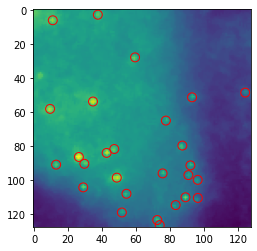

In [5]:
# visualize to check that it loaded correctly
ind=0
plt.imshow(train_dict['X'][ind,...,0])
plt.scatter(train_dict['y'][ind][:,1], train_dict['y'][ind][:,0], edgecolors='r', facecolors='None', s=80)
plt.show()

# Set up model

In [6]:
# Set up required filepaths

modeldir = './models'
logdir = './logs'

# create directories if they do not exist
for d in (modeldir, logdir):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            
print('model dir: ', modeldir)
print('log dir: ', logdir)

model dir:  ./models
log dir:  ./logs


In [7]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

conv_model_name = 'example_conv_dots_model'

n_epoch = 10  # Number of training epochs
norm_method = None  # data normalization - options are: 'std','max', None, 'whole_image'
receptive_field = 13  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

In [8]:
from deepcell_spots.dotnet import dot_net_2D

dots_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=tuple(train_dict['X'].shape[1:]),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

2023-07-25 22:02:50.497012: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-07-25 22:02:50.526617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 22:02:51.192642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9897 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [9]:
dots_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 128, 128, 12  501504      ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 offset_regression_head (Functi  (None, 128, 128, 2)  2070018    ['model_4[0][0]']                
 onal)                                                                                      

In [10]:
sigma=3.0
gamma=0.5
focal = False

losses = dotnet_losses.DotNetLosses(
    sigma=sigma, gamma=gamma, focal=focal)

loss = {
    'offset_regression': losses.regression_loss,
    'classification': losses.classification_loss
}

regression_weight = 1
classification_weight = 5
total_weight = regression_weight + classification_weight
    
loss_weights = {
    "offset_regression": regression_weight / total_weight,
    "classification": classification_weight / total_weight
}
dots_model.compile(loss=loss, loss_weights=loss_weights,
              optimizer=optimizer, metrics=['accuracy'])

In [11]:
rotation_range=0
flip=True
shear=0
zoom_range=0
fill_mode='nearest'
cval=0.
seed=0

datagen = image_generators.ImageFullyConvDotDataGenerator(
    rotation_range=rotation_range,
    shear_range=shear,
    zoom_range=zoom_range,
    horizontal_flip=flip,
    vertical_flip=flip,
    fill_mode=fill_mode,
    cval=cval)

# DataGenerator object for validation data - generates data with no augmentation
datagen_val = image_generators.ImageFullyConvDotDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)

train_data = datagen.flow(
    train_dict,
    seed=seed,
    batch_size=batch_size)

val_data = datagen_val.flow(
    val_dict,
    seed=seed,
    batch_size=batch_size)

# Train model

In [ ]:
num_gpus=1
loss_history = dots_model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            modeldir, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=num_gpus >= 2),
        callbacks.TensorBoard(log_dir=os.path.join(logdir, conv_model_name))
    ])

# Test model

In [ ]:
y_pred_test = dots_model.predict(test_dict['X'])
print('Test image result shape:', y_pred_test[0].shape)

In [ ]:
ind = 0
# plots results with restrictive decision
fig,ax=plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(test_dict['X'][ind,...,0], cmap='gray')
ax[0].set_title('Raw image')

# mark above threshold pixels (opaque plot over original)
threshold = 0.95
y_pred_test_dict = {}
y_pred_test_dict['classification'] = y_pred_test[1]
y_pred_test_dict['offset_regression'] = y_pred_test[0]
points_list = y_annotations_to_point_list_max(y_pred_test_dict, threshold, min_distance=1)
# plot ground truth centers, and predictions
ax[1].imshow(y_pred_test[1][ind,:,:,1], vmax=vmax, cmap='gray')
ax[1].scatter(points_list[ind][:,1], points_list[ind][:,0], edgecolors='r',
              facecolors='None', s=200, label='Predicted')
ax[1].plot(test_dict['y'][ind][:,1], test_dict['y'][ind][:,0], 'xb', label='GT')
ax[1].legend()
ax[1].set_title('Classification prediction')